# Classification

In the following notebook we will plot and show the classification result for the FE simulation of ARMCO pure iron. 

The classification result come from executing the file 
     *tda_shotpeening/src/classifier_compute.py*

It calculates the scores of 10-fold CV for the following classes of classifiers:
1. TDA specific:
    * Support Vector Classifier using kernels defined on persistence diagrams
    * Different Classifiers used for vector representations of the persistence diagram
2. scalar-features:
    * Using one or several different scalar based features
    * features can either be tda-based or conventional
    * one method computes the perfomance for different classifiers while the other does a parametersearch for Suppport Vector Classifiers

and brings it in the right format, so that we can directly use seaborn plotting functionality.

To avoid multiple mentions of the same Classifier, we pick the best ones if there are several different hyperparamateres for the classifier present. The scoring works on the mean of the 10-fold accuracy as well as the F1-Score. In addition, we save the scores for standard scaler and minmaxscaler as well.

For the cross-validation we split along the sequences. That is the numerical simulations which come in different sequences consisting of 5-6 samples in each sequence with different coverage classes.

Furthermore, we can have different postprocessing stages of the surfaces. (WILL come ltaer, but not really of interest.)

In [1]:
%load_ext autoreload
%autoreload 2

In [14]:
import numpy as np
import pandas as pd

from sklearn import preprocessing

import matplotlib.pyplot as plt
from matplotlib.ticker import StrMethodFormatter
import seaborn as sns

# import path variables
from src.config import data_path_processed, data_path_classification, figures_path
# import simulation parameters
from src.config import simulation_parameters

from src.auxiliary import savefig_severalformats, check_load_file

Only load the smaller csv.

In [3]:
processed = simulation_parameters['simulation_processed']

number_run = 0

train_size = simulation_parameters['train_size']
n_cross_val = simulation_parameters['n_cross_val']
random_state_cv = simulation_parameters['random_state_cv']

filename_base = data_path_classification
file_appendix = simulation_parameters["calculation_method"]
file_appendix_run = f'{simulation_parameters["calculation_method"]}_run-{number_run}_CV-{n_cross_val}'
file_appendix_run += f'_RS-{random_state_cv}-TS-{int(train_size*100)}'

In [4]:
filepath = filename_base / f'classifier_{file_appendix_run}.csv'
clf_scores = check_load_file(filepath)  

The columns of the classifier dataframe consists of the perfomance for certain classifier combinations. 

Columns
* feature: shows if we use persistence diagrams as input, single scalar based features or a collection of scalar based ones.
* accuracy: score of perfomance of this particular classifier for the input data specified
* f1_macro: score of perfomance of this particular classifier for the input data specified
* test: If 'test' it's the perfomance on the test set and 'train' for training set
* split: number of the split in the 10-fold Cross-Validation
* dim: for TDA methods it shows the dimension of the homology group considered
* processed: the postprocessing scheme used for the surface

* param_Clf: the Classifier used
* param_TDA: If using persistence diagrams (PD) as input, the vectorization of the PD or the TDA-kernel method to be used with a SVM
* param_Scaler: if a scaler (standardscaler or minmaxscaler) was used
* param_DimReduction: If LDA or PCA was used.
* params: combination of all the params_ columns with more information

Using labelencoder on 'params' we get unique identifiers for each classifier.

In [5]:
clf_scores.head(3)

,feature,accuracy,f1_macro,test,split,dim,processed,param_Clf,param_TDA,param_Scaler,param_Dim_reduction,params
0,PersDiag_repre,0.877551,0.874903,test,0,0.0,nom_filt,RandomForestClassifier(),Landscape(),NaN,NaN,"{'Clf': RandomForestClassifier(), 'Clf__random..."
1,PersDiag_repre,1.000000,1.000000,train,0,0.0,nom_filt,RandomForestClassifier(),Landscape(),NaN,NaN,"{'Clf': RandomForestClassifier(), 'Clf__random..."
2,PersDiag_repre,0.938776,0.938064,test,1,0.0,nom_filt,RandomForestClassifier(),Landscape(),NaN,NaN,"{'Clf': RandomForestClassifier(), 'Clf__random..."


All parameters calculated. We will only use few of these.

In [6]:
np.unique(clf_scores['feature'])

array(['Conv_all', 'Conv_selec', 'PersDiag_repre', 'Sa', 'Sdq', 'Sdr',
       'Sku', 'Sq', 'Ssk', 'Sz', 'amplitude_betti_0',
       'amplitude_landscape_0', 'amplitude_silhouette_0',
       'entropy_gudhi_0', 'max_pers_0', 'tda_selec'], dtype=object)

## Show persistence diagram (PD) based classifiers

All conventional parameteres as input
0 [0.91998299] SVM
1 [0.90569558] DT
2 [0.90373639] RF
3 [0.90573129] MLP
4 [0.89557483] KN
Skewness and interfacial developed area ratio
0 [0.94272619] SVM
1 [0.89986054] DT
2 [0.92231293] RF
3 [0.93447789] MLP
4 [0.90394558] KN
Single feature: Skewness
0 [0.93056122] SVM
1 [0.8732466] DT
2 [0.8732466] RF
3 [0.85879252] MLP
4 [0.88536735] KN
Single feature: arithmetic mean height
0 [0.60482143] SVM
1 [0.56017007] DT
2 [0.56017007] RF
3 [0.61752721] MLP
4 [0.56816667] KN


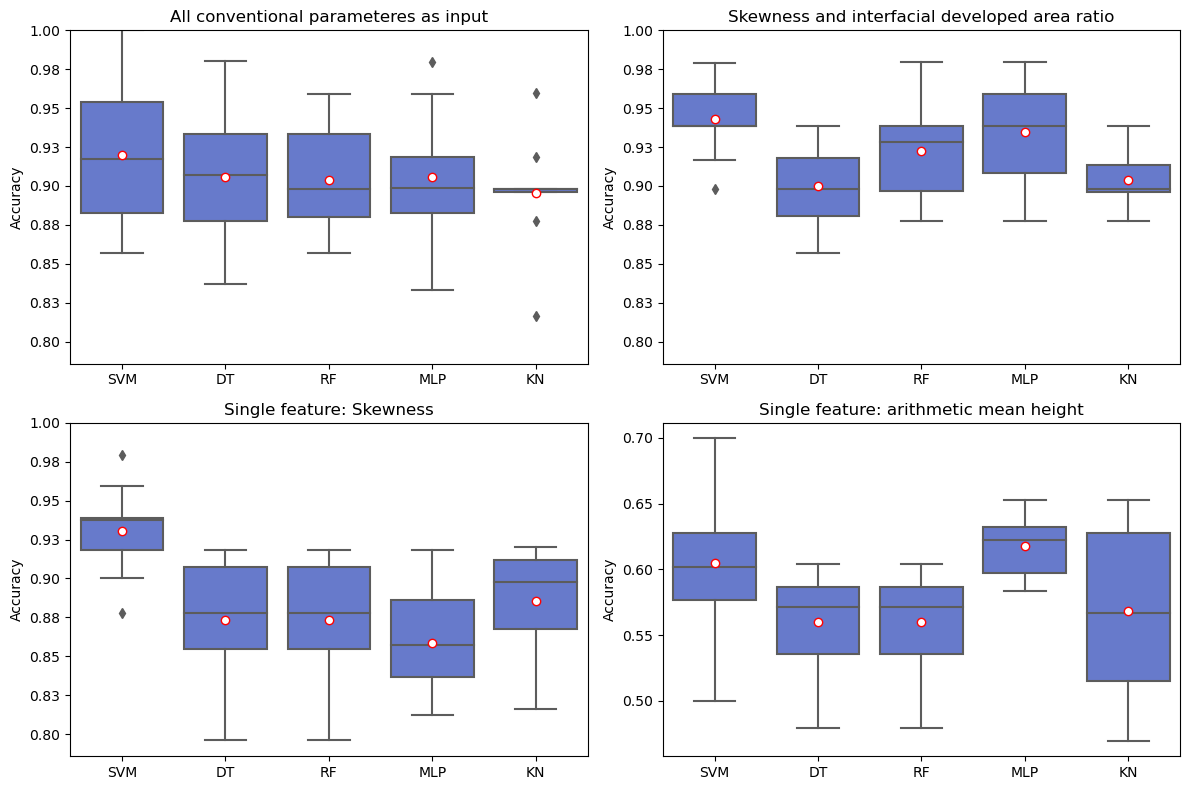

In [16]:
classifier_choice = ['SVC', 
                     'DecisionTreeClassifier',
                     'RandomForestClassifier',
                     'MLPClassifier', 
                     'KNeighborsClassifier']

features = ['Conv_all', 'Conv_selec', 'Ssk', 'Sa', ]
features_names = ['All conventional parameteres as input',
                  'Skewness and interfacial developed area ratio',
                  'Single feature: Skewness',
                  'Single feature: arithmetic mean height'
                  ]

fig = plt.figure(dpi=100, figsize=(12,8))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2, sharey = ax1)
ax3 = fig.add_subplot(2, 2, 3, sharey = ax1)
ax4 = fig.add_subplot(2, 2, 4)

ax = np.array([[ax1, ax2], [ax3, ax4]])

for feat_i, feat in enumerate(features):
# feat_i = 0
# feat = features[0]
# filter out unncessary data
    df_plot = clf_scores[clf_scores['feature'].isin([feat])]#.copy(deep=True)
    df_plot = df_plot[df_plot['test']=='test']
    df_plot = df_plot[df_plot['processed'] == processed]

    # encode the params column to get an easier handle on which 
    # rows to groupby
    le = preprocessing.LabelEncoder()
    df_plot['param_class'] = le.fit_transform(df_plot['params'])

    # get the classifiers sorted by their perfomance
    best = df_plot.groupby(by=['param_class', 'param_Clf']).\
        mean().sort_values(['accuracy', 'f1_macro'], ascending=False)
    best = best.reset_index()

    # For each of the classifiers in our choice pick the 
    # version which performed the best
    index_pclass_clf = []
    for clf_i in classifier_choice:
        for i, row in enumerate(best['param_Clf']):
            if clf_i in row:
                index_pclass_clf.append(best.loc[i, 'param_class'])
                break
        
    # get the right order of param_classes so that it is always 
    # the same for the different plots
    order = best.loc[best['param_class'].isin(index_pclass_clf), 
                    'param_class'].values
    
    df_plot['custom_order'] = -1
    for idx in range(len(index_pclass_clf)):
        df_plot.loc[df_plot['param_class']==index_pclass_clf[idx], 'custom_order'] = idx

    df_plot = df_plot.sort_values(by='custom_order')
    # plot the boxes
    axi = np.unravel_index(feat_i, (2,2))
    sns.boxplot(data=df_plot[df_plot['custom_order']>=0],
                x='custom_order', 
                y='accuracy',
                # order=df_plot.loc[df_plot['custom_order']>=0, 'custom_order'],
                ax=ax[axi],
                showmeans=True,
                meanprops = {"marker":'o', 'markerfacecolor':'white', 'markeredgecolor':'red'},
                color=sns.color_palette("hls", 8)[5])
    ax[axi].set_xticklabels(['SVM', 'DT', 'RF', 'MLP', 'KN'])
    ax[axi].set_title(features_names[feat_i]);

    ax[axi].yaxis.set_tick_params(which='both', labelleft=True)
    ax[axi].yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
    
    ax[axi].set_ylabel('Accuracy')
    ax[axi].set_xlabel(None)
    
    # print out the mean values, as can be seen in the plot
    print(features_names[feat_i])
    xticks = ['SVM', 'DT', 'RF', 'MLP', 'KN']
    df_getmean = df_plot[df_plot['custom_order']>=0]
    df_getmean = df_getmean[['custom_order', 'param_class', 'accuracy']]
    df_getmean = df_getmean.groupby('custom_order').mean().reset_index()
    for x in np.unique(df_getmean['custom_order']):
        print(x, df_getmean.loc[df_getmean['custom_order']==x, 'accuracy'].values, xticks[x])

ax[(0,1)].set_ylim(top=1)
fig.tight_layout()

savefig_severalformats(fig, f'boxplot_conventional_{file_appendix_run}',
                       figures_path)

PLot the boxplot for the tda classifiers:

In [8]:
np.unique(clf_scores['feature'])

array(['Conv_all', 'Conv_selec', 'PersDiag_repre', 'Sa', 'Sdq', 'Sdr',
       'Sku', 'Sq', 'Ssk', 'Sz', 'amplitude_betti_0',
       'amplitude_landscape_0', 'amplitude_silhouette_0',
       'entropy_gudhi_0', 'max_pers_0', 'tda_selec'], dtype=object)

Selection of 0D persistence-based features
0 [0.99587585] SVM
1 [0.96534184] DT
2 [0.99179422] RF
3 [0.98567177] MLP
4 [0.9897534] KN
vectorization:
0 [0.9795068] BC
1 [0.88757313] LS
2 [0.89965306] Si
0D Entropy
0 [1.] SVM
1 [1.] DT
2 [1.] RF
3 [1.] MLP
4 [0.99183673] KN
$L^2$ norm of the 0D Betti curve
0 [0.95288946] SVM
1 [0.92431293] DT
2 [0.92431293] RF
3 [0.94064116] MLP
4 [0.94068367] KN


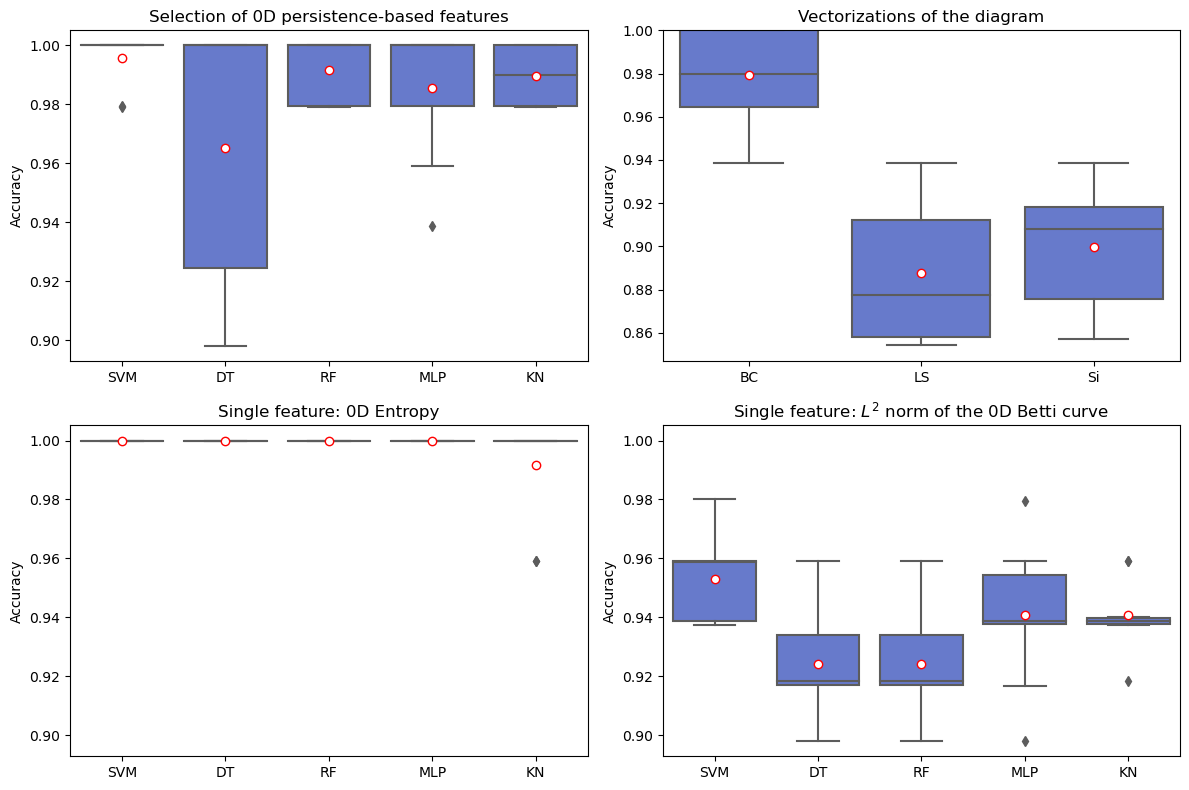

In [17]:
classifier_choice = ['SVC', 
                     'DecisionTreeClassifier',
                     'RandomForestClassifier',
                     'MLPClassifier', 
                     'KNeighborsClassifier']
tda_choice = ['']

features = ['tda_selec', 'vectorization', 'entropy_gudhi_0', 'amplitude_betti_0', 
            ]
features_names = ['Selection of 0D persistence-based features', 
                  'Vectorizations of the persistence diagrams',
                  '0D Entropy',
                  '$L^2$ norm of the 0D Betti curve'
                  ]

# fig, ax = plt.subplots(2,2, dpi=100, 
#                        figsize=(12,8),
#                        sharey=True)
fig = plt.figure(dpi=100, figsize=(12,8))

ax1 = fig.add_subplot(2, 2, 1)
ax2 = fig.add_subplot(2, 2, 2)
ax3 = fig.add_subplot(2, 2, 3, sharey = ax1)
ax4 = fig.add_subplot(2, 2, 4, sharey = ax1)

ax = np.array([[ax1, ax2], [ax3, ax4]])

for feat_i, feat in enumerate(features):
    if feat_i != 1:
        # filter out unncessary data
        df_plot = clf_scores[clf_scores['feature'].isin([feat])].copy(deep=True)
        df_plot = df_plot[df_plot['test']=='test']
        df_plot = df_plot[df_plot['processed'] == processed]

        # encode the params column to get an easier handle on which 
        # rows to groupby
        le = preprocessing.LabelEncoder()
        df_plot['param_class'] = le.fit_transform(df_plot['params'])

        # get the classifiers sorted by their perfomance
        best = df_plot.groupby(by=['param_class', 'param_Clf']).\
            mean().sort_values(['accuracy', 'f1_macro'], ascending=False)
        best = best.reset_index()

        # For each of the classifiers in our choice pick the 
        # version which performed the best
        index_pclass_clf = []
        for clf_i in classifier_choice:
            for i, row in enumerate(best['param_Clf']):
                if clf_i in row:
                    index_pclass_clf.append(best.loc[i, 'param_class'])
                    break
            
        # get the right order of param_classes so that it is always 
        # the same for the different plots
        order = best.loc[best['param_class'].isin(index_pclass_clf), 
                        'param_class'].values

        df_plot['custom_order'] = -1
        for idx in range(len(index_pclass_clf)):
            df_plot.loc[df_plot['param_class']==index_pclass_clf[idx], 'custom_order'] = idx

        df_plot = df_plot.sort_values(by='custom_order')
        # plot the boxes
        axi = np.unravel_index(feat_i, (2,2))
        sns.boxplot(data=df_plot[df_plot['custom_order']>=0],
                    x='custom_order', 
                    y='accuracy',
                    # order=df_plot.loc[df_plot['custom_order']>=0, 'custom_order'],
                    ax=ax[axi],
                    showmeans=True,
                    meanprops = {"marker":'o', 'markerfacecolor':'white', 'markeredgecolor':'red'},
                    color=sns.color_palette("hls", 8)[5])
        ax[axi].set_xticklabels(['SVM', 'DT', 'RF', 'MLP', 'KN'])

        # get the mean values to be printed
        print(features_names[feat_i])
        xticks = ['SVM', 'DT', 'RF', 'MLP', 'KN']
        df_getmean = df_plot[df_plot['custom_order']>=0]
        df_getmean = df_getmean[['custom_order', 'param_class', 'accuracy']]
        df_getmean = df_getmean.groupby('custom_order').mean().reset_index()
        for x in np.unique(df_getmean['custom_order']):
            print(x, df_getmean.loc[df_getmean['custom_order']==x, 'accuracy'].values, xticks[x])
        
        # # plot the boxes
        # axi = np.unravel_index(feat_i, (2,2))
        # sns.boxplot(data=df_plot,
        #             x='param_class', 
        #             y='accuracy',
        #             order=order,
        #             ax=ax[axi],
        #             showmeans=True)
        # ax[axi].set_xticklabels(['SVM', 'DT', 'RF', 'MLP', 'KN'])
        if feat_i>1:
            ax[axi].set_title(f'Single feature: {features_names[feat_i]}')
        else:
            ax[axi].set_title(features_names[feat_i]);
        
        ax[axi].yaxis.set_tick_params(which='both', labelleft=True)
        ax[axi].yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
        
        ax[axi].set_ylabel('Accuracy')
        ax[axi].set_xlabel(None)
    else:
        # TODO do it nicer:

        df_plot = clf_scores[clf_scores['feature'] == 'PersDiag_repre'].copy(deep=True)
        df_plot = df_plot[df_plot['test'] == 'test']
        df_plot = df_plot[df_plot['processed'] == processed]

        # all TDA representations we pick used RF_classifier
        paramTDA = ['BettiCurve()', 'Landscape()', 'Silhouette()']
        paramTDAlabels = ['BC', 'LS', 'Si']
        df_plot = df_plot[df_plot['param_TDA'].isin(paramTDA)]

        le = preprocessing.LabelEncoder()
        df_plot['param_class'] = le.fit_transform(df_plot['params'])

        # get the classifiers sorted by their perfomance
        best = df_plot.groupby(by=['param_class', 'param_TDA']).\
            mean().sort_values(['accuracy', 'f1_macro'], ascending=False)
        best = best.reset_index()

        # For each of the classifiers in our choice pick the 
        # version which performed the best
        index_pclass_clf = []
        for clf_i in paramTDA:
            for i, row in enumerate(best['param_TDA']):
                if clf_i in row:
                    index_pclass_clf.append(best.loc[i, 'param_class'])
                    break
            
        # get the right order of param_classes so that it is always 
        # the same for the different plots
        order = best.loc[best['param_class'].isin(index_pclass_clf), 
                        'param_class'].values
        
        df_plot['custom_order'] = -1
        for idx in range(len(index_pclass_clf)):
            df_plot.loc[df_plot['param_class']==index_pclass_clf[idx], 'custom_order'] = idx

        df_plot = df_plot.sort_values(by='custom_order')

        # # sort via param_class since seaborn is doing that in the plot
        # # and get the appropriate values
        # order_labels = df_plot[['param_class', 'param_TDA']].\
        #     drop_duplicates().sort_values(by='param_class')['param_TDA'].values
        # rename_dict = {'BettiCurve()' : 'BC',
        #         'Landscape()' : 'Ls',
        #         'Silhouette()' : 'Si'
        #         }
        # order_labels = [rename_dict[t] for t in order_labels]

        # plot the boxes
        axi = np.unravel_index(feat_i, (2,2))
        sns.boxplot(data=df_plot[df_plot['custom_order']>=0],
                    x='custom_order', 
                    y='accuracy',
                    ax=ax[axi],
                    meanprops = {"marker":'o', 'markerfacecolor':'white', 'markeredgecolor':'red'},
                    showmeans=True,
                    color=sns.color_palette("hls", 8)[5])
        ax[axi].set_xticklabels(paramTDAlabels)
        ax[axi].yaxis.set_major_formatter(StrMethodFormatter('{x:,.2f}'))
        
        print('vectorization:')
        xticks = paramTDAlabels
        df_getmean = df_plot[df_plot['custom_order']>=0]
        df_getmean = df_getmean[['custom_order', 'param_class', 'accuracy']]
        df_getmean = df_getmean.groupby('custom_order').mean().reset_index()
        for x in np.unique(df_getmean['custom_order']):
            print(x, df_getmean.loc[df_getmean['custom_order']==x, 'accuracy'].values, xticks[x])
            
        ax[axi].set_title('Vectorizations of the diagram');
        ax[axi].yaxis.set_tick_params(which='both', labelleft=True)
        
        ax[axi].set_ylabel('Accuracy')
        ax[axi].set_xlabel(None)
        
ax[(0,1)].set_ylim(top=1)
fig.tight_layout()

savefig_severalformats(fig, f'boxplot_tda_{file_appendix_run}',
                       figures_path)

## make table for single scalar classifier

In [10]:
np.unique(clf_scores['feature'])

array(['Conv_all', 'Conv_selec', 'PersDiag_repre', 'Sa', 'Sdq', 'Sdr',
       'Sku', 'Sq', 'Ssk', 'Sz', 'amplitude_betti_0',
       'amplitude_landscape_0', 'amplitude_silhouette_0',
       'entropy_gudhi_0', 'max_pers_0', 'tda_selec'], dtype=object)

In [11]:
single_features = ['Sa', 'Sdq', 'Sdr', 'Sku', 'Sq', 'Ssk', 'Sz', 
                   'amplitude_betti_0', 
                   'entropy_gudhi_0',
                   'amplitude_landscape_0',
                   'amplitude_silhouette_0',
                   ]

In [12]:
# df_plot = clf_scores[clf_scores['feature'].isin(single_features)].copy(deep=True)
# df_plot = df_plot[df_plot['processed'] == processed]

# params = np.unique([params for params in df_plot['params'] if 'GaussianNB()' not in params])
# df_plot = df_plot[df_plot['params'].isin(params)]
# np.unique(df_plot['params'])

In [13]:
single_features = ['Sa', 'Sdq', 'Sdr', 'Sku', 'Sq', 'Ssk', 'Sz', 
                   'amplitude_betti_0', 
                   'entropy_gudhi_0',
                   'amplitude_landscape_0',
                   'amplitude_silhouette_0',
                   ]

df_plot = clf_scores[clf_scores['feature'].isin(single_features)].copy(deep=True)
df_plot = df_plot[df_plot['processed'] == processed]

# exlude GaussianNB
params = np.unique([params for params in df_plot['params'] if 'GaussianNB()' not in params])
df_plot = df_plot[df_plot['params'].isin(params)]

le = preprocessing.LabelEncoder()
df_plot['param_class'] = le.fit_transform(df_plot['params'])

df_plot = df_plot.groupby(by=['feature', 'param_class', 'test']).mean()
df_plot = df_plot.reset_index()

best_param_class = []
df_result = []
for feat in single_features:
    df_tmp = df_plot[(df_plot['test'] == 'test') & (df_plot['feature']==feat)]
    df_tmp = df_tmp.sort_values(by=['accuracy', 'f1_macro'], ascending=False)

    best_param_class.append(df_tmp.iloc[0]['param_class'])
    tmp_array = {'feature':feat,
                 'accuracy_test': df_tmp.iloc[0]['accuracy'],
                 'f1_macro_test': df_tmp.iloc[0]['f1_macro'],
                 'param_class':le.inverse_transform([df_tmp.iloc[0]['param_class']])
    }
    df_pick = df_plot[(df_plot['test'] == 'train') 
                     & (df_plot['feature']==feat)
                     & (df_plot['param_class']==df_tmp.iloc[0]['param_class'])
                    ]
    tmp_array['accuracy_train'] = df_pick['accuracy'].values[0]
    tmp_array['f1_macro_train'] = df_pick['f1_macro'].values[0]
    
    df_result.append(tmp_array)

df_result = pd.DataFrame(df_result)
df_result = df_result[['feature', 'accuracy_test', 'accuracy_train',
                       'f1_macro_test', 'f1_macro_train', 'param_class']]

filepath = filename_base / f'table_excel_{file_appendix_run}.csv'
df_result.to_csv(filepath, index=False)